In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.feature import canny
from skimage.filters import gaussian

In [2]:
def align_single_scale(channel_to_align, reference_channel, search_range=5):
    """
    Align channel_to_align to reference_channel using exhaustive search with NCC
    Returns: (best_dx, best_dy, aligned_channel)
    """
    best_score = -1  # For NCC, higher is better (range -1 to 1)
    best_displacement = (0, 0)

    margin = 60  # Adjust this value

    ref_inner = reference_channel[margin:-margin, margin:-margin]
    channel_inner = channel_to_align[margin:-margin, margin:-margin]
    for dx in range(-search_range, search_range + 1):
        for dy in range(-search_range, search_range + 1):
            shifted = np.roll(channel_to_align, dx, axis=1)
            shifted = np.roll(shifted, dy, axis=0)

            # Only compute metric on inner region (exclude borders)
            ref_inner = reference_channel[margin:-margin, margin:-margin]
            shifted_inner = shifted[margin:-margin, margin:-margin]

            # Compute Normalized Cross-Correlation (NCC)
            # Flatten arrays for easier computation
            ref_flat = ref_inner.flatten()
            shifted_flat = shifted_inner.flatten()
            
            # Subtract means (center the data)
            ref_centered = ref_flat - np.mean(ref_flat)
            shifted_centered = shifted_flat - np.mean(shifted_flat)
            
            # Compute normalized cross-correlation
            numerator = np.dot(ref_centered, shifted_centered)
            denominator = np.linalg.norm(ref_centered) * np.linalg.norm(shifted_centered)
            
            if denominator > 0:
                ncc_score = numerator / denominator
            else:
                ncc_score = -1  # Worst possible score
            
            # For NCC, higher values are better
            if ncc_score > best_score:
                best_score = ncc_score
                best_displacement = (dx, dy)
    best_aligned = np.roll(channel_to_align, best_displacement[0], axis=1)
    best_aligned = np.roll(best_aligned, best_displacement[1], axis=0)

    return best_displacement[0], best_displacement[1], best_aligned

In [3]:
def colorize_image(image_path):
    # Read and convert image
    im = skio.imread(image_path)
    im = sk.img_as_float(im)

    # Split into BGR channels (top to bottom)
    height = im.shape[0] // 3
    b = im[:height]                    # Blue (reference)
    g = im[height:2*height]            # Green (align to blue)
    r = im[2*height:3*height]          # Red (align to blue)

    # Align G and R to B
    g_dx, g_dy, aligned_g = align_single_scale(g, b)
    r_dx, r_dy, aligned_r = align_single_scale(r, b)

    # Print displacements
    print(f"Green channel displacement: ({g_dx}, {g_dy})")
    print(f"Red channel displacement: ({r_dx}, {r_dy})")

    # Create RGB color image (note: BGR -> RGB conversion)
    color_image = np.dstack([aligned_r, aligned_g, b])
    skio.imshow(color_image)
    skio.show()

    return color_image

Green channel displacement: (5, 5)
Red channel displacement: (5, 5)


/var/folders/f1/h8rqd2ts7wg6xp5372dxsg740000gn/T/ipykernel_65003/2798854859.py:22: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  skio.imshow(color_image)
/opt/homebrew/Caskroom/miniforge/base/envs/image_processing/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: divide by zero encountered in matmul
  return rgb @ coeffs
/opt/homebrew/Caskroom/miniforge/base/envs/image_processing/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: overflow encountered in matmul
  return rgb @ coeffs
/opt/homebrew/Caskroom/miniforge/base/envs/image_processing/lib/python3.11/site-packages/skimage/color/colorconv.py:984: RuntimeWarning: invalid value encountered in matmul
  return rgb @ coeffs
/var/folders/f1/h8rqd2ts7wg6xp5372dxsg740000gn/T/ipykernel_65003/2798854859.py:23: FutureWarning: `show` is deprecated since version 0.25 and will be remo

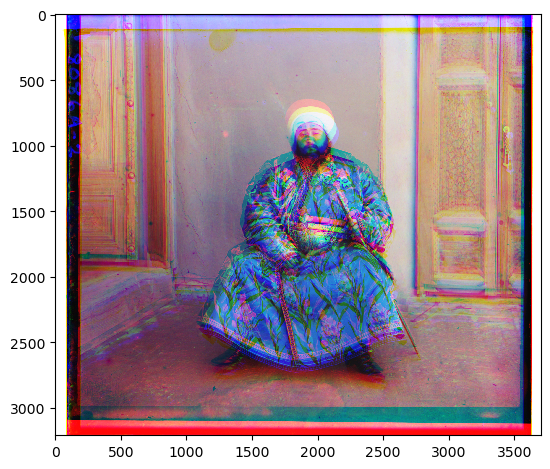

In [6]:
color_image = colorize_image('/Users/junwei/Fall2025/CS180/cs180 proj1 data/emir.tif')